In [2]:
%%capture

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os

from sklearn.model_selection import train_test_split
from keras.models import Sequential 
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout

In [8]:
DATADIR = "Dataset"

train_a = pd.read_csv(os.path.join(DATADIR, "training-a.csv"))
train_b = pd.read_csv(os.path.join(DATADIR, "training-b.csv"))
train_c = pd.read_csv(os.path.join(DATADIR, "training-c.csv"))
train_d = pd.read_csv(os.path.join(DATADIR, "training-d.csv"))
train_e = pd.read_csv(os.path.join(DATADIR, "training-e.csv"))

train_a = train_a.drop(columns=["original filename", "scanid", "contributing team", "database name original"])
train_b = train_b.drop(columns=["original filename", "scanid", "contributing team", "database name original"])
train_c = train_c.drop(columns=["original filename", "scanid", "contributing team", "database name original"])
train_d = train_d.drop(columns=["original filename", "scanid", "database name original", "num"])
train_e = train_e.drop(columns=["original filename", "districtid", "institutionid", "gender", "age", "datestamp", "scanid", "database name original"])


# Combine the DataFrames
combined_train = pd.concat([train_a, train_b, train_c, train_d, train_e], axis=0, ignore_index=True)

# Check the result
combined_train.head()

,filename,digit,database name
0,a00000.png,5,training-a
1,a00001.png,3,training-a
2,a00002.png,1,training-a
3,a00003.png,7,training-a
4,a00004.png,0,training-a


In [9]:
img_size = 28
def load_image(file_path, label, isBgWhite):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_size, img_size))
    if isBgWhite:
        img = 1 - img / 255.0
    else:
        img = img / 255.0
    return img, label

In [10]:
images, labels = [], []

for _, row in combined_train.iterrows():
    img, label = load_image(os.path.join(DATADIR, row["database name"], row["filename"]), row["digit"], 
                            False if row["database name"] == "training-e" else True)
    images.append(img)
    labels.append(label)

images = np.array(images)
images = np.expand_dims(images, -1)

labels = np.array(labels)
labels = tf.keras.utils.to_categorical(labels)

In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

In [12]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(28, 28, 1), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dropout(0.2))

model.add(Dense(10, activation="softmax"))

model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer='adam'
)

/Users/sagnikbarik/Developer/Machine Learning/Bengali Digit Recognition/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-02-13 10:58:26.293435: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-02-13 10:58:26.293467: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-02-13 10:58:26.293487: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-02-13 10:58:26.293542: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-13 10:58:26.293559: I tensorflow/core/comm

In [13]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'cnn_best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

history = model.fit(
    X_train, y_train, 
    batch_size=128,
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[checkpoint],
    verbose=1
)

Epoch 1/30


2025-02-13 10:58:30.063928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


451/451 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4714 - loss: 1.5376
Epoch 1: val_accuracy improved from -inf to 0.84027, saving model to cnn_best_model.keras
451/451 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.4718 - loss: 1.5366 - val_accuracy: 0.8403 - val_loss: 0.5496
Epoch 2/30
450/451 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8267 - loss: 0.5578
Epoch 2: val_accuracy improved from 0.84027 to 0.88182, saving model to cnn_best_model.keras
451/451 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.8268 - loss: 0.5576 - val_accuracy: 0.8818 - val_loss: 0.3912
Epoch 3/30
449/451 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8682 - loss: 0.4076
Epoch 3: val_accuracy improved from 0.88182 to 0.90478, saving model to cnn_best_model.keras
451/451 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.8683 - loss: 0.4075 - val_accuracy: 0.9048 - val_loss: 0.3162
Epoch 4/30
450/451 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8933 - loss: 0.3315
Epoch 4: val_accuracy improved

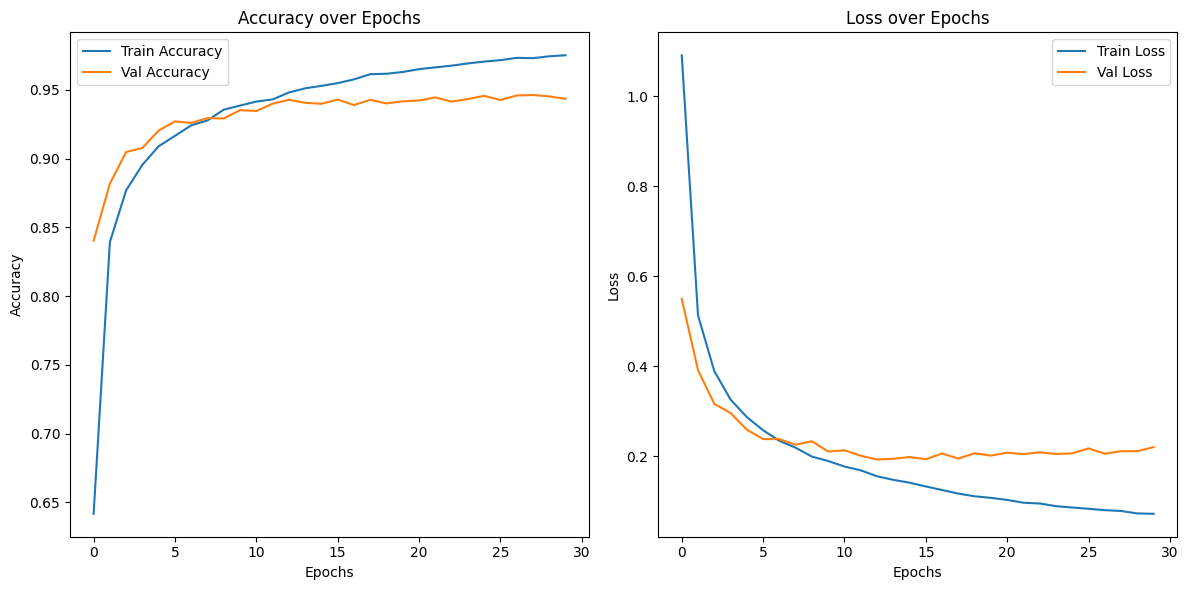

In [14]:
# Plot training and validation accuracy and loss curves
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.tight_layout()
plt.show()

In [15]:
# Load the best model
best_model = tf.keras.models.load_model('cnn_best_model.keras')

# Test the model on the test dataset
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9421 - loss: 0.2249
Test Accuracy: 0.9414


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


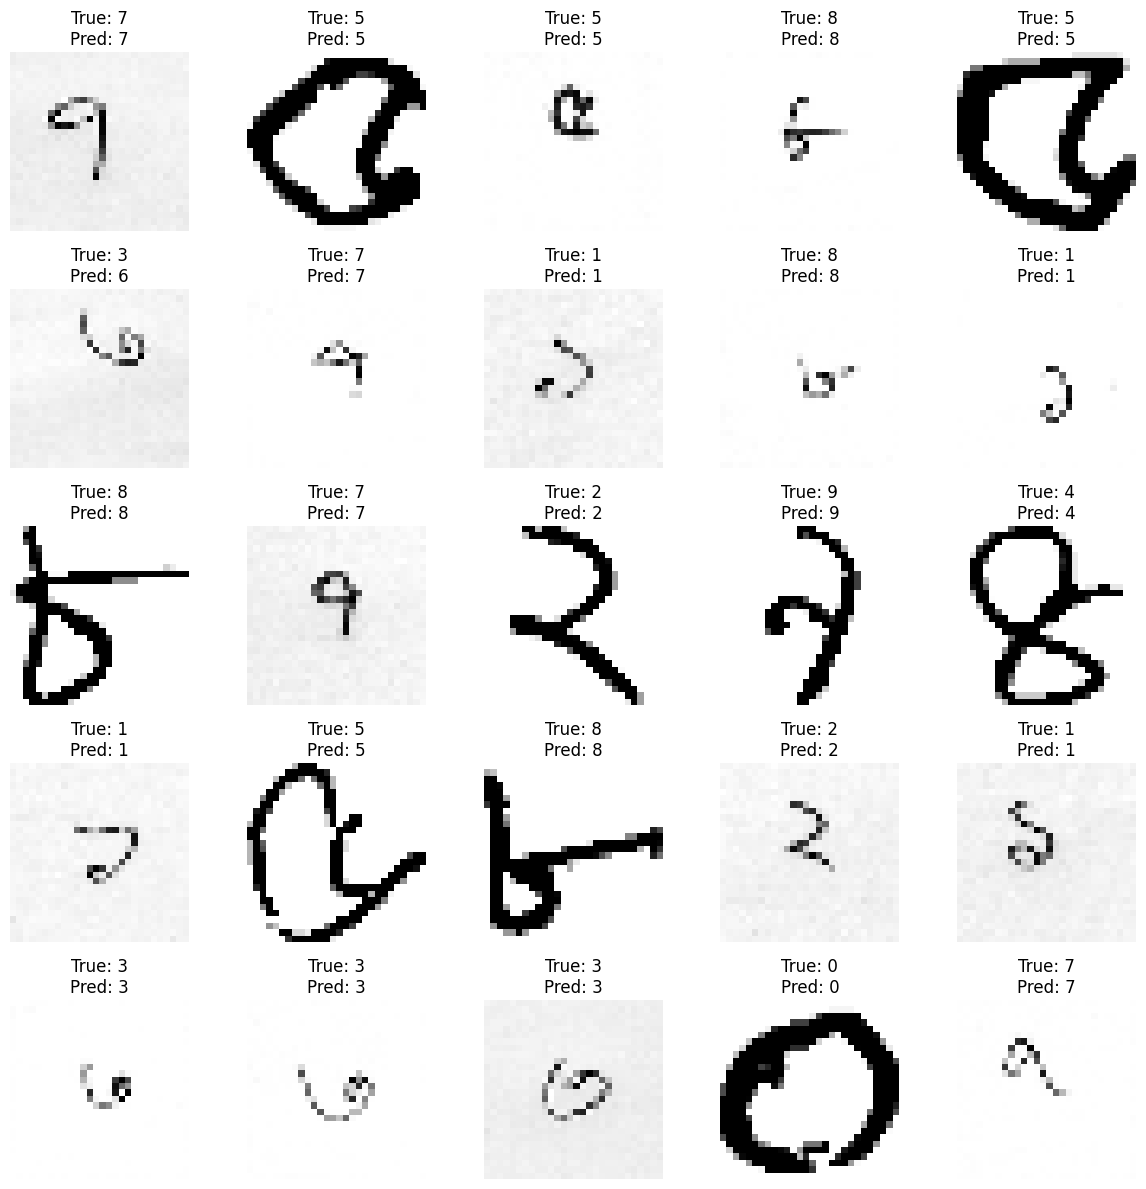

In [19]:
# Visualize predicted labels with actual labels
predictions = best_model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Plot a few predictions
plt.figure(figsize=(12, 12))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_test[i].squeeze(), cmap='binary')
    plt.title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()